# Лабораторная работа № 3. Регрессионный анализ.


In [309]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")


### 1. а) генерация параметров распределения; б) генерация многомерного нормального распределения с заданными параметрами.

In [310]:
# мультипликативный конгруэнтный метод  (Линейный конгруэнтный метод)
# a = 123, c = 0, m = seed = 0x7fffffff = 2147483647

def myRandom(m):
    a = 123
    seed = 1
    
    while True:
        seed = (seed * a) % m
        yield seed

m = 0.55

def get_random_val():
    global m
    m += 0.5
    r = myRandom(m)
    boot = []
    for _ in range(1000):
        tmp = next(r)
        boot.append(tmp)
    boot = sum(boot) / len(boot)
    return boot

def get_mean():
    mean = np.array([get_random_val(), get_random_val(), get_random_val()])
    return tuple(mean)

def get_cov():
    while True:
        a1 = get_random_val()
        a2 = get_random_val()
        a3 = get_random_val()
        a4 = get_random_val()
        a5 = get_random_val()
        a6 = get_random_val()
        cov = np.array([[a1, a2, a3],
                        [a2, a4, a5],
                        [a3, a5, a6]])
        if np.linalg.det(cov) > 0:
            return cov

In [311]:
mean, cov = get_mean(), get_cov()

In [312]:
print("norm vector: ", mean, "\n\ncov matrix:\n", cov)

norm vector:  (0.5256527956256279, 0.7848357743094704, 0.9900392393086354) 

cov matrix:
 [[5.76295987 6.18717308 6.42603352]
 [6.18717308 6.45472609 6.87237604]
 [6.42603352 6.87237604 7.03505572]]


In [313]:
df = np.random.multivariate_normal(mean, cov, 101)
df = pd.DataFrame(data=df, columns=[["x1", "x2", "x3"]])

In [314]:
df.head()

,x1,x2,x3
0,0.740796,1.141160,1.591445
1,4.001525,4.548335,4.324772
2,1.659484,1.744040,1.910333
3,-0.494733,-0.066164,0.319808
4,0.807990,0.519158,0.973485


In [315]:
df.corr()

,x1,x2,x3
x1,1.000000,0.973623,0.978997
x2,0.973623,1.000000,0.976860
x3,0.978997,0.976860,1.000000


### 2. Случайным образом удалить из выборки одно трехмерное наблюдение и сохранить отдельно.

In [316]:
get_index = np.random.random_integers(0, 101)
sample = df.loc[get_index]
df = df.drop(get_index)
# print(sample)
# print("size df: ", df[:, 0].size)

In [317]:
df.shape

(100, 3)

3. Обозначим компоненты сгенерированного нормального вектора как (x1, x2, x3). Предположим,
что имеет место модель линейной регрессии: x1 = a0 + a2x2 + a3x3 + u, где u – независимые в
совокупности нормально распределенные ошибки (остатки, residuals). **Оценить коэффициенты
линейной регрессии a0, a2, a3, математическое ожидание и дисперсию ошибки u. (Можно
использовать готовые методы)**

In [318]:
def split_data(df):
    X = df[["x2", "x3"]]
    y = df["x1"]
    return X, y

In [319]:
def get_residual(X, y, reg):
    prediction = reg.predict(X)
    residual = (y - prediction)
#     print(residual.head(5).values, "\n")
    print(residual.describe().T[["mean", "std"]])
    return residual

In [320]:
def get_MSE(pred, y):
    return (pred - y)**2

In [321]:
X, y = split_data(df)

In [322]:
from sklearn.linear_model import LinearRegression

In [323]:
reg = LinearRegression().fit(X=X, y=y)

In [324]:
# x1 = a0 + a2x2 + a3x3 + u

print("a2, a3:", *reg.coef_)
print("a0:\t", *reg.intercept_)

a2, a3: [0.35139388 0.56393849]
a0:	 -0.31031051423947154


In [325]:
get_residual(X, y, reg)

            mean       std
x1  3.536060e-16  0.323642


,x1
0,-0.247367
1,0.274672
2,0.279639
3,-0.341525
4,0.386886
...,...
96,-0.258503
97,0.608032
98,-0.410458
99,-0.256381


4. Для отдельно сохраненного вектора, по компонентам x2 и x3, используя модель линейной регрессии, спрогнозировать компоненту x1. **Найти квадрат разности точного значения этой компоненты и прогноза (квадрат ошибки).**

In [326]:
x2_x3, x1 = split_data(pd.DataFrame(sample).T)
x2_x3

,x2,x3
14,-0.93297,-0.699921


In [327]:
predicted = reg.predict(x2_x3)

In [328]:
get_MSE(predicted, x1)

,x1
14,0.713535


5. Повторить шаги 1-4 M = 100 раз. На каждой итерации на первом шаге использовать одни и те
же параметры. Насколько «хорошо» прогнозируется значение x1. Усреднить квадрат ошибки
(получим среднеквадратичную ошибку прогнозирования). Сделать выводы.

In [329]:
def MSE_n(reg):
    boot = []
    for i in range(1, 100):
        X, y = split_data(df.iloc[i-1:i,])
        predicted = reg.predict(X)
        predicted = float(predicted)
        MSE_stat = get_MSE(predicted, y)
        boot.append(MSE_stat)

    MSE_n = np.average(boot)

    return MSE_n


In [330]:
MSE_n(reg)

0.10473052758125424

## Разное

6. (+1 балл) **Найти истинные коэффициенты регрессии модели из пункта 3, сравнить
полученные результаты.**

In [331]:
# аналитический метод нахождения коэффициентов
# не тот метод!!!

def mse_analitic_solution(X, y):
    ones = np.ones(shape=[X.shape[0], 1])
    A = np.concatenate([ones, X], axis=1)
    return np.linalg.inv((A.T.dot(A))).dot(A.T).dot(y)

In [332]:
bw = mse_analitic_solution(X, y)
w, b = bw[1:], bw[0]
print("a2, a3: ", w.T)
print("a0:\t", b)

a2, a3:  [[0.35139388 0.56393849]]
a0:	 [-0.31031051]


In [333]:
print(reg.coef_, 
reg.intercept_)

[[0.35139388 0.56393849]] [-0.31031051]


In [334]:
df.head()

,x1,x2,x3
0,0.740796,1.141160,1.591445
1,4.001525,4.548335,4.324772
2,1.659484,1.744040,1.910333
3,-0.494733,-0.066164,0.319808
4,0.807990,0.519158,0.973485


In [335]:
mean[0]

0.5256527956256279

In [336]:
# x1 = a0 + a2x2 + a3x3 + u

# x0 = a0 + a2x1 + a3x2 + u

def real_coef(mean, cov):
    cov_x = np.array([[cov[1,1], cov[1,2]], [cov[2,1], cov[2,2]]])
    cov_x_i_y = np.array([[cov[0,1], cov[0,2]]])
    mean_x = np.array([mean[1], mean[2]])
    
    coef = np.linalg.inv(cov_x) @ cov_x_i_y.T
    intercept = mean[0] - coef.T @ mean_x
    
    return coef, intercept

In [337]:
coef_real, intercept_real = real_coef(mean, cov)

In [338]:
print("coef: \n", coef_real)
print("intercept:", intercept_real)

coef: 
 [[0.34887006]
 [0.57262762]]
intercept: [-0.31507673]


In [339]:
print("coef: \n", reg.coef_)
print("intercept:", reg.intercept_)

coef: 
 [[0.35139388 0.56393849]]
intercept: [-0.31031051]


7. (+0,5 балла) Предположим, что имеет место модель линейной регрессии: x1 = a2x2 + a3x3 + u,
где u – независимые в совокупности нормально распределенные ошибки (остатки, residuals). Оценить
коэффициенты линейной регрессии a2, a3, математическое ожидание и дисперсию ошибки u.
Сравнить полученные результаты с результатами пункта 3. Сравнить среднеквадратическую ошибку
прогнозирования в этом случае с ошибкой из пункта 5.

In [340]:
df = df.append(pd.DataFrame([list(sample)], columns=df.columns), ignore_index=True)
df.head()

,x1,x2,x3
0,0.740796,1.141160,1.591445
1,4.001525,4.548335,4.324772
2,1.659484,1.744040,1.910333
3,-0.494733,-0.066164,0.319808
4,0.807990,0.519158,0.973485


In [341]:
df

,x1,x2,x3
0,0.740796,1.141160,1.591445
1,4.001525,4.548335,4.324772
2,1.659484,1.744040,1.910333
3,-0.494733,-0.066164,0.319808
4,0.807990,0.519158,0.973485
...,...,...,...
96,1.568647,1.228072,1.488439
97,-0.499180,0.066971,0.351200
98,0.334169,0.553518,1.252545
99,2.853519,3.645883,3.403040


In [342]:
X, y = split_data(df)

In [343]:
reg_full = LinearRegression().fit(X, y)

In [344]:
reg_full.coef_

array([[0.35113622, 0.55980513]])

In [345]:
reg_full.intercept_

array([-0.29655286])

In [346]:
# x1 = a2x2 + a3x3 + u

df.head()

,x1,x2,x3
0,0.740796,1.141160,1.591445
1,4.001525,4.548335,4.324772
2,1.659484,1.744040,1.910333
3,-0.494733,-0.066164,0.319808
4,0.807990,0.519158,0.973485


In [347]:
X, y = split_data(df)

reg_without_intercept = LinearRegression(fit_intercept=False).fit(X=X, y=y)

print("a2, a3:", *reg.coef_)

a2, a3: [0.35139388 0.56393849]


In [348]:
get_residual(X, y, reg_without_intercept)

        mean       std
x1 -0.164383  0.364188


,x1
0,-0.364232
1,0.127170
2,0.107702
3,-0.538870
4,0.239760
...,...
96,0.438333
97,-0.631726
98,-0.328026
99,-0.235399


In [349]:
MSE_n(reg_without_intercept)

0.15784203512677458

## Графики

8. (+1 балл) Сгенерировать выборку из пункта 1. На графике изобразить диаграмму рассеяния
компонент x1 и x2. Предположим, что имеет место модель линейной регрессии: x1 = a0 + a2x2 + u.
Оценить коэффициенты данной модели. Построить на графике линию регрессии x1 = a0 + a2x2.

In [535]:
df.head()

,x1,x2,x3
0,0.740796,1.141160,1.591445
1,4.001525,4.548335,4.324772
2,1.659484,1.744040,1.910333
3,-0.494733,-0.066164,0.319808
4,0.807990,0.519158,0.973485


(-4.684041573819634, 5.105166566317408, -3.841066594531604, 5.563648642916626)

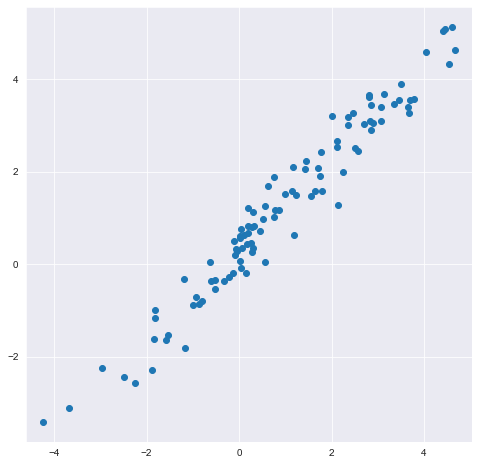

In [536]:
# mean = [1, 2, 2]
# cov = [[1, 0, 0], [0, 0.5, 0], [0,0,2]]  # diagonal covariance

# df = np.random.multivariate_normal(mean, cov, 1000).T

import matplotlib.pyplot as plt
plt.plot(df.iloc[:, 1], df.iloc[:, 2], 'o')
plt.axis('equal')


(-3.4135795382839573,
 5.13616158666898,
 -4.6941089588664235,
 5.3165816522999725)

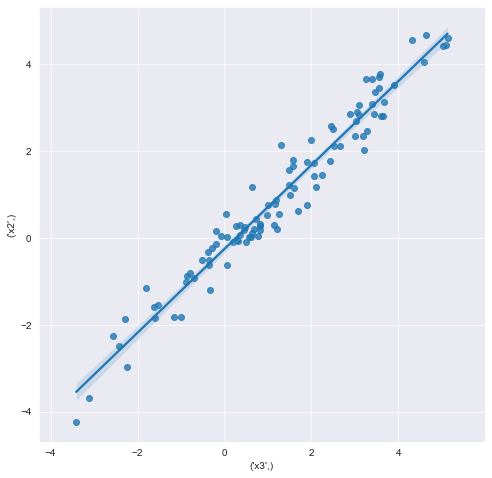

In [537]:
sns.regplot(df.iloc[:, 2], df.iloc[:, 1])
plt.axis('equal')

9. (+0,5 балла) Для остатков модели из пункта 8 (или пункта 3) построить q-q plot. Разобраться,
что на нем изображается и дать содержательную интерпретацию того, что получилось в вашем
случае.

In [538]:
# x1 = a0 + a2x2 + u.
X = df["x2"]
y = df["x1"]

reg_8 = LinearRegression(fit_intercept=True).fit(X, y) 

residuals = get_residual(X, y, reg_8)

            mean       std
x1 -1.780754e-16  0.405538


## Хи-квадрат критерий Пирсона


10. (+2 балл) Реализовать хи-квадрат критерий Пирсона для проверки гипотезы о том, что
остатки модели из пункта 3 имеют нормальный закон распределения. Из встроенных функций
разрешается использовать только функции распределения (cdf), плотности (pdf) и функции для
вычисления квантилей различных законов распределений (quantiles).

In [539]:
X_bar = residuals.values.mean()
s = residuals.values.std()

print("mean: ", X_bar, "std: ", s)

mean:  -1.692815304874001e-16 std:  0.4035254730994696


In [540]:
residuals = np.array(residuals)
residuals = residuals.reshape(101)

In [541]:
from scipy.stats import chi2, norm

In [542]:
# Плотность вероятности (Probability density function)     (pdf)
# Функция распределения (Cumulative distribution function) (cdf)
# Функция квантилей (Quantile function) (ppf) (если cdf = f(x), то ppf = (f(x))^-1)

# PDF: Probability Density Function, returns the probability of a given continuous outcome.
# CDF: Cumulative Distribution Function, returns the probability of a value less than or equal to a given outcome.
# PPF: Percent-Point Function, returns a discrete value that is less than or equal to the given probability.


In [543]:
def calc_bins(k):
    bins = [-float("inf")]
    for i in range(k-1):
        p = (i+1) / k
        z = norm.ppf(p)
        bound = X_bar + z*s
        bins.append(bound)
    bins.append(float("inf"))
    return bins

bins = calc_bins(20)

In [544]:
bins

[-inf,
 -0.6637403379949718,
 -0.517138701787751,
 -0.41822727383156855,
 -0.3396156064480696,
 -0.27217379554861715,
 -0.2116089649841168,
 -0.15548662350202222,
 -0.10223200965125387,
 -0.05070755444001046,
 -1.692815304874001e-16,
 0.05070755444001018,
 0.10223200965125354,
 0.1554866235020219,
 0.21160896498411638,
 0.2721737955486168,
 0.3396156064480693,
 0.4182272738315682,
 0.5171387017877506,
 0.6637403379949711,
 inf]

In [545]:
def observed_expected_freq(residuals, bins, k):
    frequency = []
    boot_obs, boot_expect = [], []
    expected = np.round(len(residuals) / k)
#     print("observed   expected")
    for i in range(k):
        observed = sum(num >= bins[i] and num < bins[i+1] for num in residuals)
#         expected = sum(num >= bins[i] and num < bins[i+1] for num in normal) / 1000
#         expected = 5
#         print(observed,"\t  ", expected)
        frequency.append((observed, expected))
    return frequency


In [546]:
frequency = observed_expected_freq(residuals, bins, 20)

In [547]:
def mine_chi_square(k):
    bins = calc_bins(k)
    frequency = observed_expected_freq(residuals, bins, k)
    
    # ddof = k - 3
    crit = chi2.ppf(0.95, k - 3)
    chi_square = sum([(x[0] - x[1])**2./x[1] for x in frequency])
    p_value = 1 - chi2.cdf(chi_square, k - 3)
    print("chi_square: \t", chi_square, "\ncrit: \t\t", crit, "\np_value: \t", p_value)
    return chi_square, crit, p_value

In [548]:
chi_square, crit, p_value = mine_chi_square(20)

chi_square: 	 17.8 
crit: 		 27.58711163827534 
p_value: 	 0.4015621606313511


In [549]:
# print("chi_square: \t", chi_square, "\ncrit: \t\t", crit, "\np_value: \t", p_value)

11. (+0,5 балла) Сравнить полученные результаты с результатами работы встроенного теста.

In [550]:
from scipy.stats import chisquare

In [551]:
chisquare(f_obs = boot_obs, f_exp = boot_expect, ddof=2) # k - 1 - ddof => если k = 20, тогда ddof = 2

Power_divergenceResult(statistic=17.8, pvalue=0.40156216063135103)

12. (+0,5 балла) Определить, для каких значений k числа интервалов нулевая гипотеза
принимается, для каких отвергается (k изменять от 3 до 50).

In [552]:
class color:
    GREEN = '\033[92m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    END = '\033[0m'

print(color.BOLD + 'Hello World !' + color.END)

Hello World !


In [553]:
boot_chi_square = []
for i in range(4, 50):
    chi_square, crit, p_value = mine_chi_square(i)
    if chi_square >= crit:
        print(i, ": ", color.BOLD + color.RED + "REGECT H0 hypothesis" + color.END, "\n")
    else:
        print(i, ": ", color.BOLD + color.GREEN + "TAKE H0 hypothesis" + color.END, "\n")

chi_square: 	 2.2800000000000002 
crit: 		 3.841458820694124 
p_value: 	 0.13105187368373616
4 :  TAKE H0 hypothesis 

chi_square: 	 0.95 
crit: 		 5.991464547107979 
p_value: 	 0.6218850564650201
5 :  TAKE H0 hypothesis 

chi_square: 	 4.176470588235294 
crit: 		 7.814727903251179 
p_value: 	 0.24302820861361252
6 :  TAKE H0 hypothesis 

chi_square: 	 6.214285714285714 
crit: 		 9.487729036781154 
p_value: 	 0.1837066221013628
7 :  TAKE H0 hypothesis 

chi_square: 	 3.6153846153846154 
crit: 		 11.070497693516351 
p_value: 	 0.6060048509918468
8 :  TAKE H0 hypothesis 

chi_square: 	 4.181818181818182 
crit: 		 12.591587243743977 
p_value: 	 0.6520865626722352
9 :  TAKE H0 hypothesis 

chi_square: 	 4.1 
crit: 		 14.067140449340169 
p_value: 	 0.768190036531649
10 :  TAKE H0 hypothesis 

chi_square: 	 6.666666666666667 
crit: 		 15.50731305586545 
p_value: 	 0.5729859919108071
11 :  TAKE H0 hypothesis 

chi_square: 	 13.125 
crit: 		 16.918977604620448 
p_value: 	 0.15703124215238495
1

## Переобучение (over fitting)

13. (+1 балл). Сгенерировать M выборок из двумерного нормального закона распределения
объема N с нулевым математическим ожиданием и недиагональной матрицей ковариации. В каждой
выборке случайным образом выбрать 10% наблюдений, которые исключаются из выборки и
хранятся отдельно (проверочные выборки). По оставшимся наблюдениям оценить коэффициенты
регрессии 
u для фиксированного параметра p. Спрогнозировать
значения x1 для проверочных выборок и найти среднеквадратическую ошибку прогнозирования
(усреднение идет по объему проверочной выборки и по M). Изучить, как изменяется
среднеквадратическая ошибка прогнозирования в зависимости от p.

In [683]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [759]:
def task_10(N, p, M):

    for m in range(M):
        mean, cov = get_mean()[0:2], get_cov()[0:2, 0:2]

        df = np.random.multivariate_normal(mean, cov, N)
        df = pd.DataFrame(data=df, columns=[["x1", "x2_1"]])

        for i in range(2, p+1):
            df["x2_" + str(i)] = df["x2_1"] ** i

        train, test = train_test_split(df, test_size=0.1)

        model = LinearRegression()
        model.fit(X=train.drop(columns=["x1"]), y=train.x1)

        pred_test = model.predict(test.drop(columns=["x1"]))
        pred_train = model.predict(train.drop(columns=["x1"]))
        
        mse_test = mean_squared_error(pred_test, test.x1)
        mse_train = mean_squared_error(pred_train, train.x1)
        
        print("M =", m+1 , color.BOLD + "\tTest data:" + color.END,  "\tMSE:",
              mse_test, "\n\t\t\tR_2:", r2_score(pred_test, test.x1))
        print(color.BOLD + "\tTrain data:" + color.END,  "\tMSE:", mse_train, "\n\t\t\tR_2:", r2_score(pred_train, train.x1))
        if (abs(mse_train - mse_test) > 3):
            print(color.RED + color.BOLD + "OVERFITTUING!!!" + color.END)
        print()

In [760]:
task_10(100, 10, 4)

M = 1 	Test data: 	MSE: 2.1548745911785203 
			R_2: 0.995619089349465
	Train data: 	MSE: 1.6506100147617808 
			R_2: 0.9963457588907871

M = 2 	Test data: 	MSE: 11.210699174435906 
			R_2: 0.9850940917123245
	Train data: 	MSE: 10.88871607878437 
			R_2: 0.977997360794852

M = 3 	Test data: 	MSE: 23.961049534884317 
			R_2: 0.9104025028830445
	Train data: 	MSE: 42.2777916509715 
			R_2: 0.9047203375456959
OVERFITTUING!!!

M = 4 	Test data: 	MSE: 23.002459417119187 
			R_2: 0.9487741145193099
	Train data: 	MSE: 15.284583042673317 
			R_2: 0.9714165152607729
OVERFITTUING!!!



In [ ]:
# ниже мусор!

In [740]:
N = 100
p = 10
mean, cov = get_mean()[0:2], get_cov()[0:2, 0:2]

print("norm vector: ", mean, "\n\ncov matrix:\n", cov)

norm vector:  (290.9971191687914, 285.53665707029415) 

cov matrix:
 [[310.61952533 312.5300088 ]
 [312.5300088  307.58236589]]


In [670]:
df = np.random.multivariate_normal(mean, cov, N)

df = pd.DataFrame(data=df, columns=[["x1", "x2_1"]])
df.head()

,x1,x2_1
0,79.701079,82.022292
1,87.483834,91.949499
2,94.073276,95.254325
3,97.034297,101.401279
4,114.568324,114.738465


In [671]:
# x_1 = a0 + a1 * x_2 + a2 * x2^2 + a3 * x2^2 + ... + u 

for i in range(2, p+1):
    df["x2_" + str(i)] = df["x2_1"] ** i

In [672]:
df.head()

,x1,x2_1,x2_2,x2_3,x2_4,x2_5,x2_6,x2_7,x2_8,x2_9,x2_10
0,79.701079,82.022292,6727.656442,5.518178e+05,4.526136e+07,3.712441e+09,3.045029e+11,2.497602e+13,2.048591e+15,1.680301e+17,1.378222e+19
1,87.483834,91.949499,8454.710367,7.774064e+05,7.148213e+07,6.572746e+09,6.043607e+11,5.557066e+13,5.109695e+15,4.698339e+17,4.320099e+19
2,94.073276,95.254325,9073.386444,8.642793e+05,8.232634e+07,7.841940e+09,7.469787e+11,7.115295e+13,6.777627e+15,6.455982e+17,6.149602e+19
3,97.034297,101.401279,10282.219416,1.042630e+06,1.057240e+08,1.072055e+10,1.087078e+12,1.102311e+14,1.117757e+16,1.133420e+18,1.149302e+20
4,114.568324,114.738465,13164.915289,1.510522e+06,1.733150e+08,1.988590e+10,2.281677e+12,2.617961e+14,3.003809e+16,3.446524e+18,3.954489e+20


In [673]:
train, test = train_test_split(df, test_size=0.1)
train.shape

(90, 11)

In [675]:
model = LinearRegression()
model.fit(X=train.drop(columns=["x1"]), y=train.x1)

LinearRegression()

### calculate metrix for **test samples**

In [678]:
pred_test = model.predict(test.drop(columns=["x1"]))
pred_test

array([[ 93.56115262],
       [109.40859151],
       [ 96.07632378],
       [100.80980148],
       [ 73.92063979],
       [ 88.72958023],
       [107.4331347 ],
       [100.38820075],
       [104.48449195],
       [102.31260686]])

In [679]:
test.x1

,x1
22,95.051139
87,104.229651
40,96.690903
54,99.140177
70,73.818965
16,83.323680
60,101.349240
91,101.364984
50,104.827224
67,99.824359


In [682]:
mean_squared_error(test.x1, pred_test)

10.571764873958907

In [684]:
r2_score(test.x1, pred_test)

0.8800818268375687

### calculate metrix for **train samples**

In [687]:
pred_train = model.predict(train.drop(columns=["x1"]))

In [688]:
mean_squared_error(train.x1, pred_train)

3.9518414926273855

In [689]:
r2_score(train.x1, pred_train)

0.9606396307514697

**Переобучение!!! mse сильно отличается на train и test выборке**

14. (+0,5 балла) Для первой выборки построить несколько диаграмм рассеяния. На них
изобразить линии регрессии при различных значениях p.